# Applied Econometrics (Part 2)
## Lviv Data Science Summer School

### Jozef Barunik

**July 2019**

In [16]:
options(repr.plot.width=8, repr.plot.height=4)

Let's install required packages first, please change the path

In [3]:

rm(list = ls())
library(FinTS)
library(ggplot2)
library(igraph,warn.conflicts=F)
library(MASS,warn.conflicts=F)
library(lmtest)
library(tseries)
library(forecast)
library(vars)
library(mAr)

# setwd("~/PHD/2019_Lviv/")

# Vector Autoregression (VAR$(p)$)
Let's consider $d$-variate, strictly stationary process, with components $X_{t,j}$, $j=1,\ldots,d$; i.\,e. $X_t = (x_{1,t}, ..., x_{d,t})'$, 
$$X_t = A + B_1X_{t-1} + B_2 X_{t-2} + ... + B_pX_{t-p} + \epsilon_t$$,
where $E(\epsilon_t)=0$, $E(e_t e_t')=\Omega$ being covariance matrix.

In bivariate VAR(1) case, we have 

$$
\left(\begin{array}{c} x_{1,t} \\ x_{2,t} \end{array}\right) = 
\left({\begin{array}{c} \alpha_1 \\ \alpha_2 \end{array}}\right) + 
\left(\begin{array}{cc} \beta_{1,1} & \beta_{1,2}\\ \beta_{2,1} & \beta_{2,2} \end{array}\right)
\left(\begin{array}{c} x_{1,t-1} \\ x_{2,t-1} \end{array}\right) +
\left(\begin{array}{c} \epsilon_{1,t} \\ \epsilon_{2,t} \end{array}\right)
$$

or equivalently as system of equations

$$x_{1,t} = \alpha_1 + \beta_{1,1} x_{1,t-1} + \beta_{1,2} x_{2,t-1} + \epsilon_{1,t} $$
$$x_{2,t} = \alpha_2 + \beta_{2,1} x_{1,t-1} + \beta_{2,2} x_{2,t-1} + \epsilon_{2,t}$$

Let's simulate $x_{1,t}$, and $x_{2,t}$ from this model

$$
\left(\begin{array}{c} x_{1,t} \\ x_{2,t} \end{array}\right) = 
\left({\begin{array}{c} 0.1 \\ 0.2 \end{array}}\right) + 
\left(\begin{array}{cc} 0.4 & 0.6\\ 0.1 & 0.3 \end{array}\right)
\left(\begin{array}{c} x_{1,t-1} \\ x_{2,t-1} \end{array}\right) +
\left(\begin{array}{c} \epsilon_{1,t} \\ \epsilon_{2,t} \end{array}\right)
$$

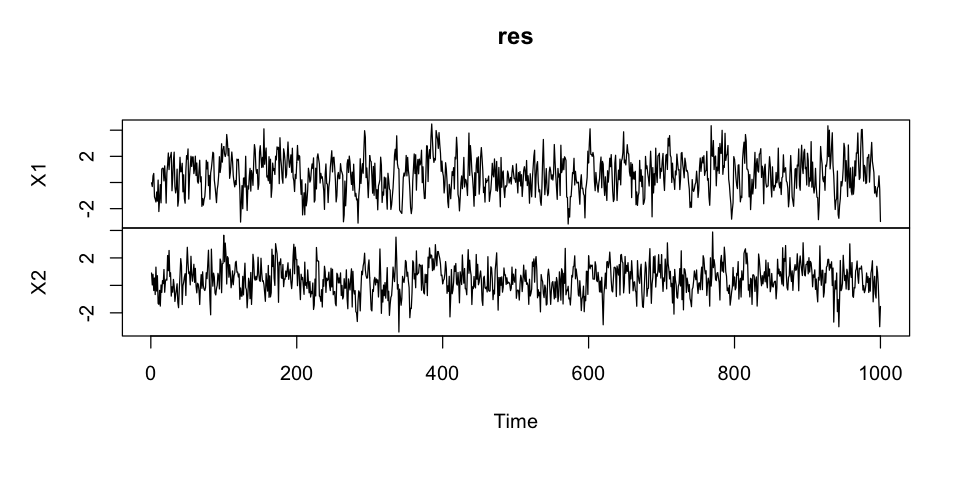

In [12]:
A = c(0.1,0.2)
cov = rbind(c(1,0),c(0,1))
B = rbind(c(0.4,0.6),c(0.1,0.3))
res <- mAr.sim(A, B, cov, N=1000)

plot.ts(res)

Usual diagnostics first, similar to univariate modelling, first observe ACF/PACF

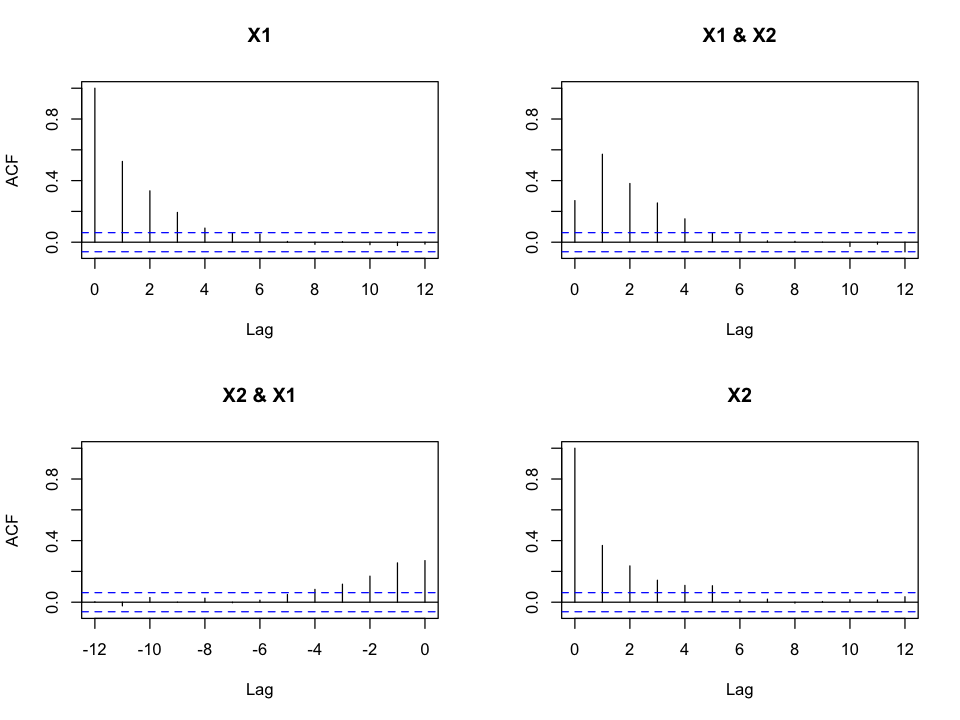

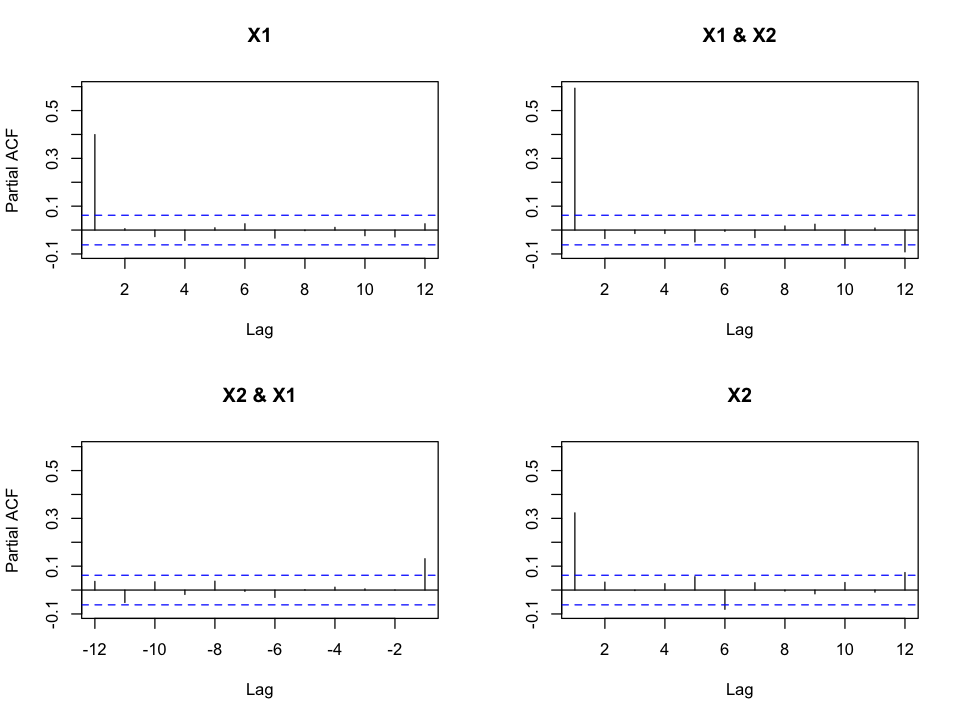

In [17]:
options(repr.plot.width=8, repr.plot.height=6)
acf(res, lag.max = 12)
pacf(res, lag.max = 12)

Plots indicate that there is ACF dependence, but also some dependence between  $x_{1,t}$, and $x_{2,t}$ (of course, we have created it). 

This type of (causal) dependence is key for VAR modelling.

*Excercise:* try to change parameters and causal versus contemporaneous dependence.

## Wold Decomposition and MA representation
Every covariance-stationary time series $X_t$ can be written as MA$(\infty)$
$$
X_t = \sum_{j=0}^\infty \theta_j \epsilon_{t-j}
$$
with $\theta_0=1$, and $\sum_{j=0}^\infty |\theta_j| < \infty$, $\epsilon_t$ being Gaussian white noise.

This is very important since it allows to look at influence of shocks.

## IRFs
VAR models are often difficult to interpret. Impulse response functions (due to  MA$(\infty)$ representation) allow to study the interactions.

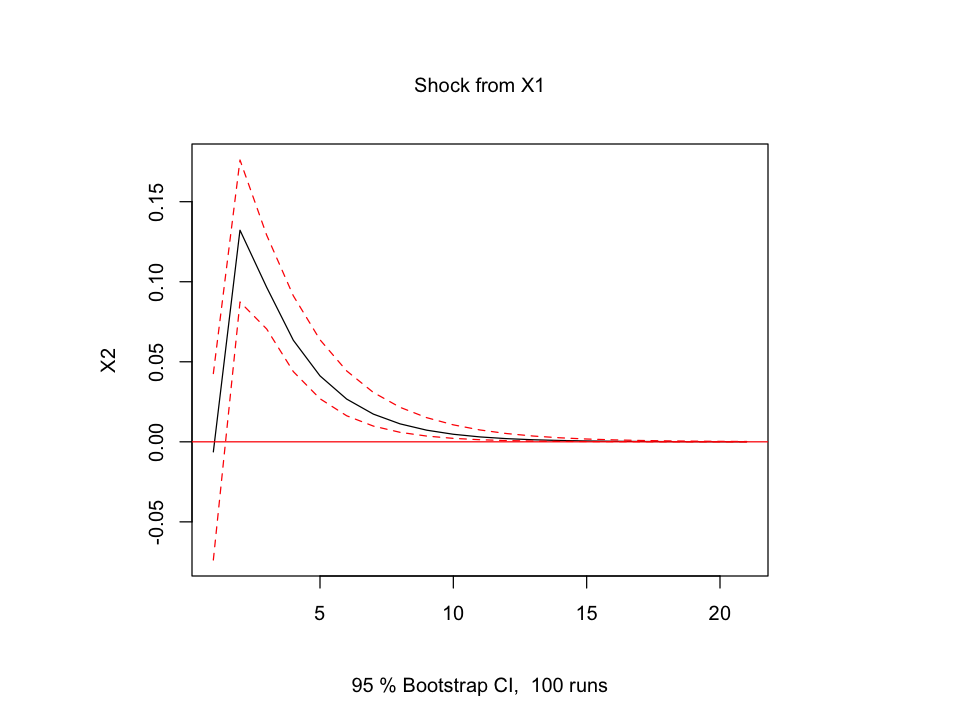

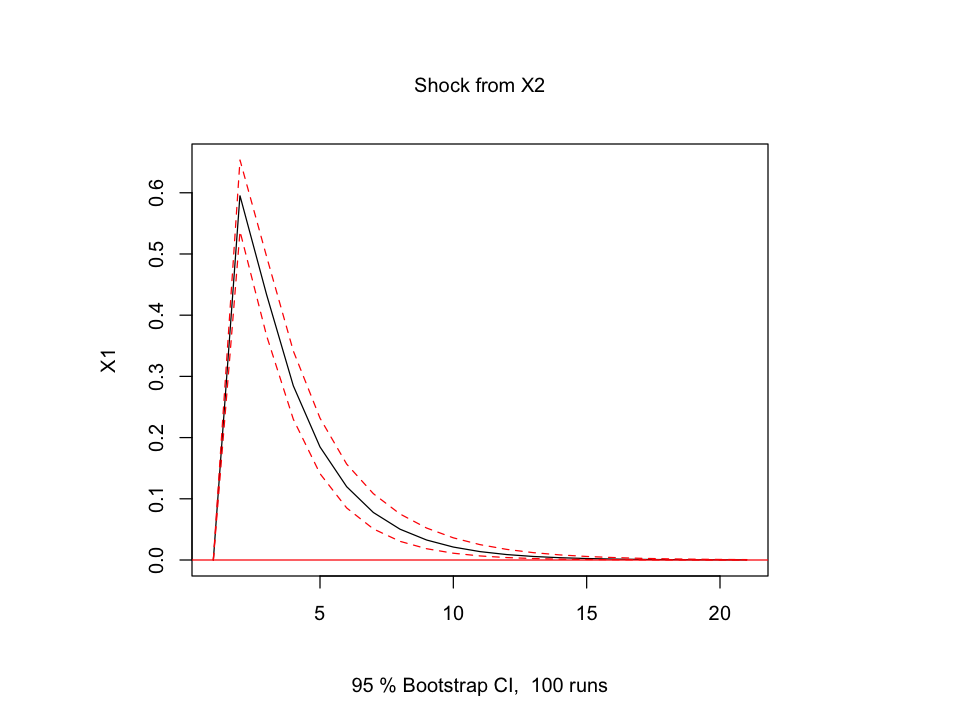

In [18]:
# first estimate the parameters
var.2c <- VAR(res, p = 1, type = "const")

irf.gdp1 <- irf(var.2c , impulse = "X1", response = "X2", n.ahead = 20)
plot(irf.gdp1, ylab = "X2", main = "Shock from X1")

irf.gdp2 <- irf(var.2c , impulse = "X2", response = "X1", n.ahead = 20)
plot(irf.gdp2, ylab = "X1", main = "Shock from X2")

## FEVDs
Forecast error variance decomposition (FEVD) show amount of information each variable contributes to the other variables in the autoregression. It determines how much of the forecast error variance of each of the variables can be explained by exogenous shocks to the other variables.

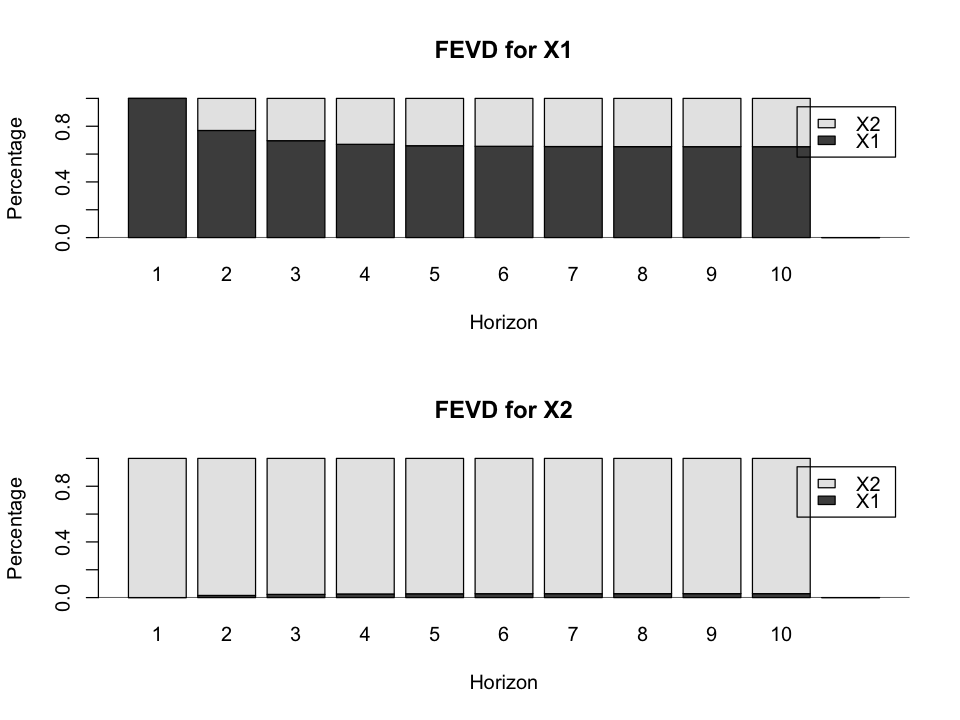

In [19]:
options(repr.plot.width=8, repr.plot.height=6)
bv.vardec <- fevd(var.2c, n.ahead = 10)
plot(bv.vardec)

## Granger causality
Is one variable useful in forecasting of another?

In [20]:
causality(var.2c, cause = "X1")
causality(var.2c, cause = "X2")

$Granger

	Granger causality H0: X1 do not Granger-cause X2

data:  VAR object var.2c
F-Test = 31.845, df1 = 1, df2 = 1992, p-value = 1.909e-08


$Instant

	H0: No instantaneous causality between: X1 and X2

data:  VAR object var.2c
Chi-squared = 0.039645, df = 1, p-value = 0.8422



$Granger

	Granger causality H0: X2 do not Granger-cause X1

data:  VAR object var.2c
F-Test = 382.68, df1 = 1, df2 = 1992, p-value < 2.2e-16


$Instant

	H0: No instantaneous causality between: X2 and X1

data:  VAR object var.2c
Chi-squared = 0.039645, df = 1, p-value = 0.8422



## Estimation: Choosing lag length
It is even less obvious, and more tricky in comparison to univariate models.

We can use information criteria (IC) to compare models. Best model is one with minimized information criteria, Akaike, Hannah-Quinn, Schwarz, and Final Prediction Error defined as

AIC = $\ln |\Omega| + \frac{2}{T}n d^2 \quad$

HQ = $\ln |\Omega| + \frac{2 \ln(\ln(T))}{T}n d^2 \quad$

SC = $\ln |\Omega| + \frac{\ln(T)}{T}n d^2 \quad$

FPE = $(\frac{T + m}{T - m} )^d |\Sigma| \quad$

where $T$ is number of observations, $|\Sigma|$ is determinant of covariance matrix, $m$ number of parameters in the model, and $n$ lag order, and $d$ dimension of the process.

Note that IC *penalize* number of parameters

In [21]:
VARselect(res, lag.max = 4, type = "const")

,1,2,3,4
AIC(n),0.02415954,0.03058488,0.03736603,0.04218374
HQ(n),0.03538923,0.04930103,0.06356865,0.07587282
SC(n),0.05370018,0.07981929,0.10629421,0.13080568
FPE(n),1.02445378,1.03105758,1.03807340,1.04308715


In case of simulated data, IC choose lag correctly, let's hope it will be the case on real data too.


## Stability of the model

VAR needs to be covariance stationary. Usually, we check stability by evaluating characteristic polynomial

$$|I - B_1 z - ... - A_pz^p|\ne0$$
for $|z|\le 1$

In [22]:
summary(var.2c)


VAR Estimation Results:
Endogenous variables: X1, X2 
Deterministic variables: const 
Sample size: 999 
Log Likelihood: -2839.384 
Roots of the characteristic polynomial:
0.6483 0.07957
Call:
VAR(y = res, p = 1, type = "const")


Estimation results for equation X1: 
X1 = X1.l1 + X2.l1 + const 

      Estimate Std. Error t value Pr(>|t|)    
X1.l1  0.40361    0.02384  16.932  < 2e-16 ***
X2.l1  0.59639    0.03049  19.562  < 2e-16 ***
const  0.09523    0.03603   2.643  0.00834 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 1.01 on 996 degrees of freedom
Multiple R-Squared: 0.4777,	Adjusted R-squared: 0.4767 
F-statistic: 455.5 on 2 and 996 DF,  p-value: < 2.2e-16 


Estimation results for equation X2: 
X2 = X1.l1 + X2.l1 + const 

      Estimate Std. Error t value Pr(>|t|)    
X1.l1  0.13293    0.02356   5.643 2.18e-08 ***
X2.l1  0.32423    0.03013  10.762  < 2e-16 ***
const  0.21109    0.03560   5.929 4.20e-09 ***
---
Signif. codes:  0

# Application: Macro forecasting
Now that we understand the concept, we can apply it to interesting realworld problems. One of the areas where VARs are widely used is macroeconomics. Let's use the data for Canada available in the package, and build a model for economy of Canada. The original time series are published by the OECD. The sample range is from the 1stQ 1980 until 4thQ 2000.

## Data

*e* is used for employment; 

*prod* is used as a measure of labour productivity; 

*rw* assigns the real wage.

*U* is the unemployment rate and

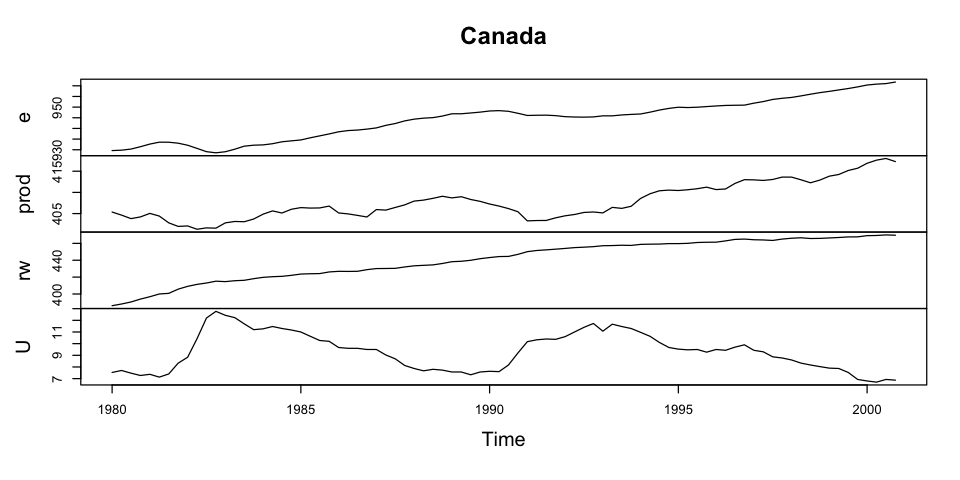

In [24]:
data(Canada)
#?Canada

options(repr.plot.width=8, repr.plot.height=4)
plot(Canada)

## Estimation and checks

In [25]:
VARselect(Canada, lag.max = 5, type = "const")

,1,2,3,4,5
AIC(n),-5.817851996,-6.35093701,-6.397756084,-6.145942174,-5.926500201
HQ(n),-5.577529641,-5.91835677,-5.772917961,-5.328846166,-4.917146309
SC(n),-5.217991781,-5.27118862,-4.838119523,-4.106417440,-3.407087295
FPE(n),0.002976003,0.00175206,0.001685528,0.002201523,0.002811116


Information criteria suggest 2 to 3 lags

In [26]:
es1 <- VAR(Canada, p = 2, type = "const")
es2 <- VAR(Canada, p = 3, type = "const")
#summary(es1)
#summary(es2)

$p=2$ seems more parsimonous, as third lag does not add much 

BUT we forgot about stationarity! *e* as well as *rw* are not stationary, butcontain strong trend! So we should put trend as well as constant

In [27]:
es3 <- VAR(Canada, p = 2, type = "both")
summary(es3)


VAR Estimation Results:
Endogenous variables: e, prod, rw, U 
Deterministic variables: both 
Sample size: 82 
Log Likelihood: -170.726 
Roots of the characteristic polynomial:
0.9071 0.9071 0.9037 0.7092 0.7092 0.2549 0.166 0.166
Call:
VAR(y = Canada, p = 2, type = "both")


Estimation results for equation e: 
e = e.l1 + prod.l1 + rw.l1 + U.l1 + e.l2 + prod.l2 + rw.l2 + U.l2 + const + trend 

          Estimate Std. Error t value Pr(>|t|)    
e.l1     1.636e+00  1.510e-01  10.830  < 2e-16 ***
prod.l1  1.716e-01  6.280e-02   2.733  0.00789 ** 
rw.l1   -6.006e-02  5.628e-02  -1.067  0.28947    
U.l1     2.740e-01  2.055e-01   1.333  0.18661    
e.l2    -4.842e-01  1.648e-01  -2.938  0.00443 ** 
prod.l2 -9.766e-02  6.747e-02  -1.448  0.15207    
rw.l2    1.689e-03  5.621e-02   0.030  0.97611    
U.l2     1.433e-01  2.108e-01   0.680  0.49886    
const   -1.510e+02  6.921e+01  -2.181  0.03244 *  
trend   -5.706e-03  1.652e-02  -0.345  0.73077    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.0

Look at fits, ACFS, residuals...

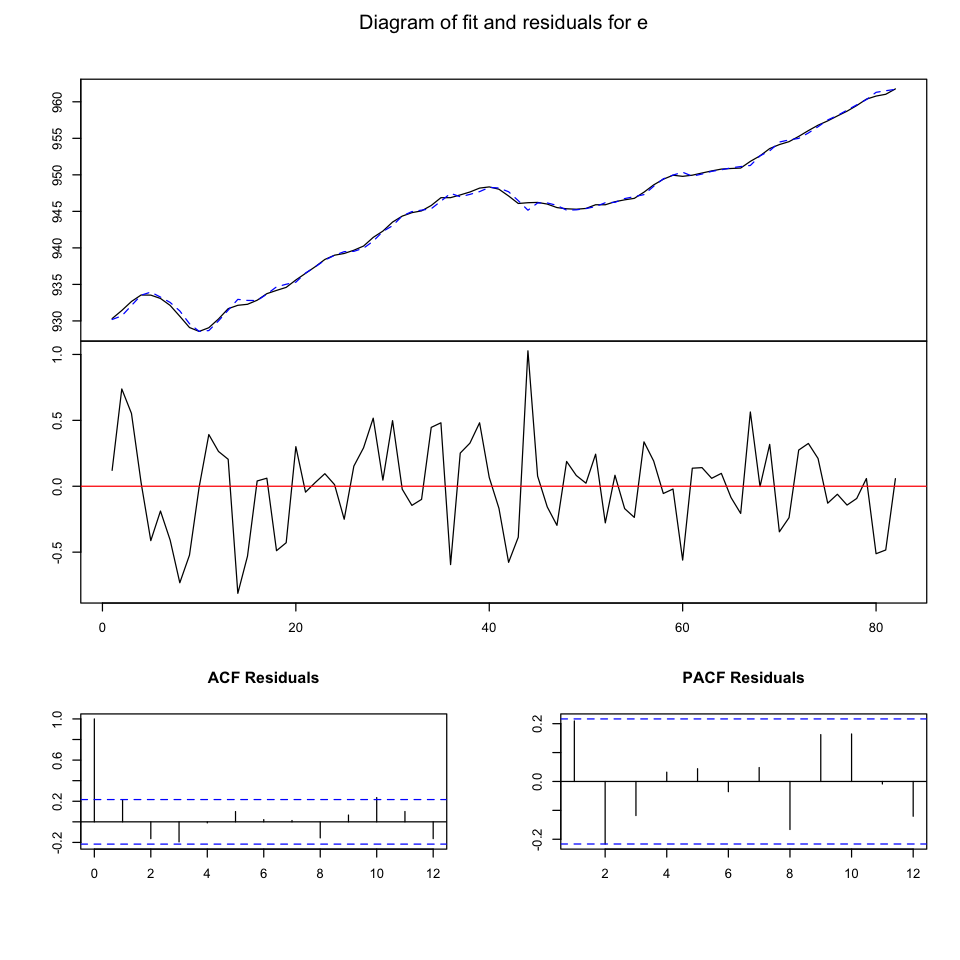

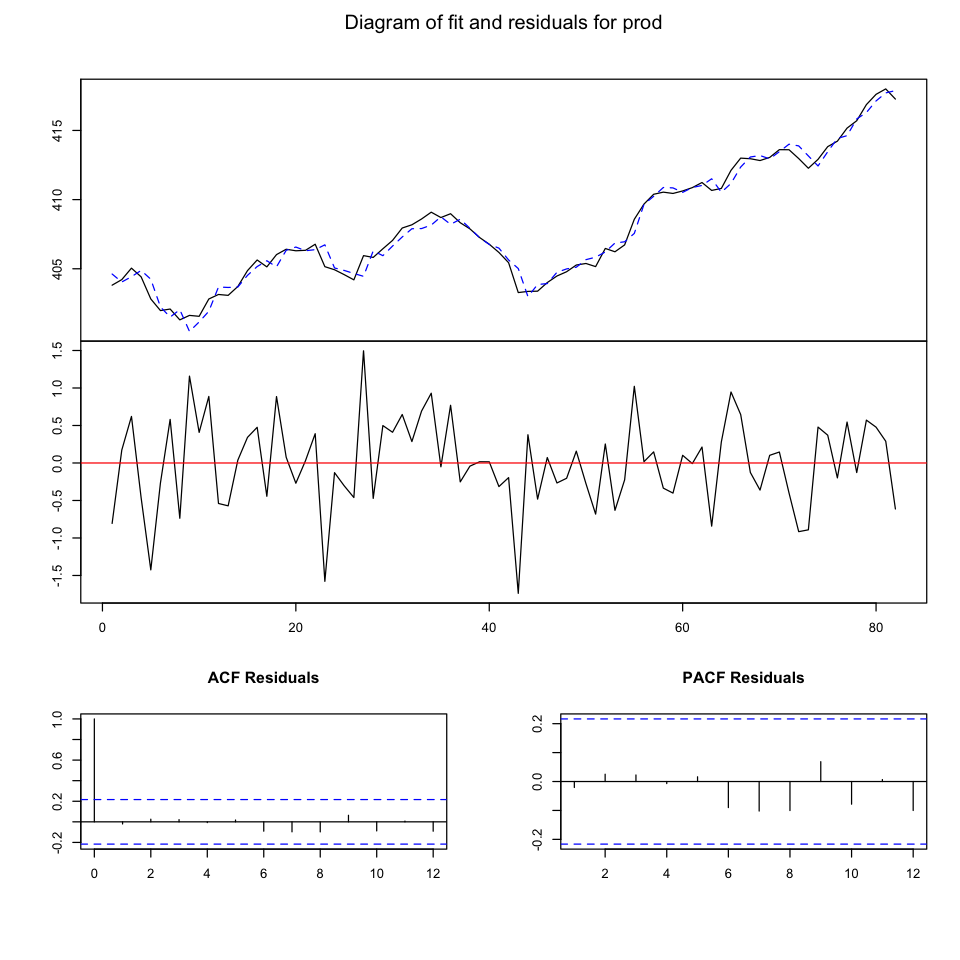

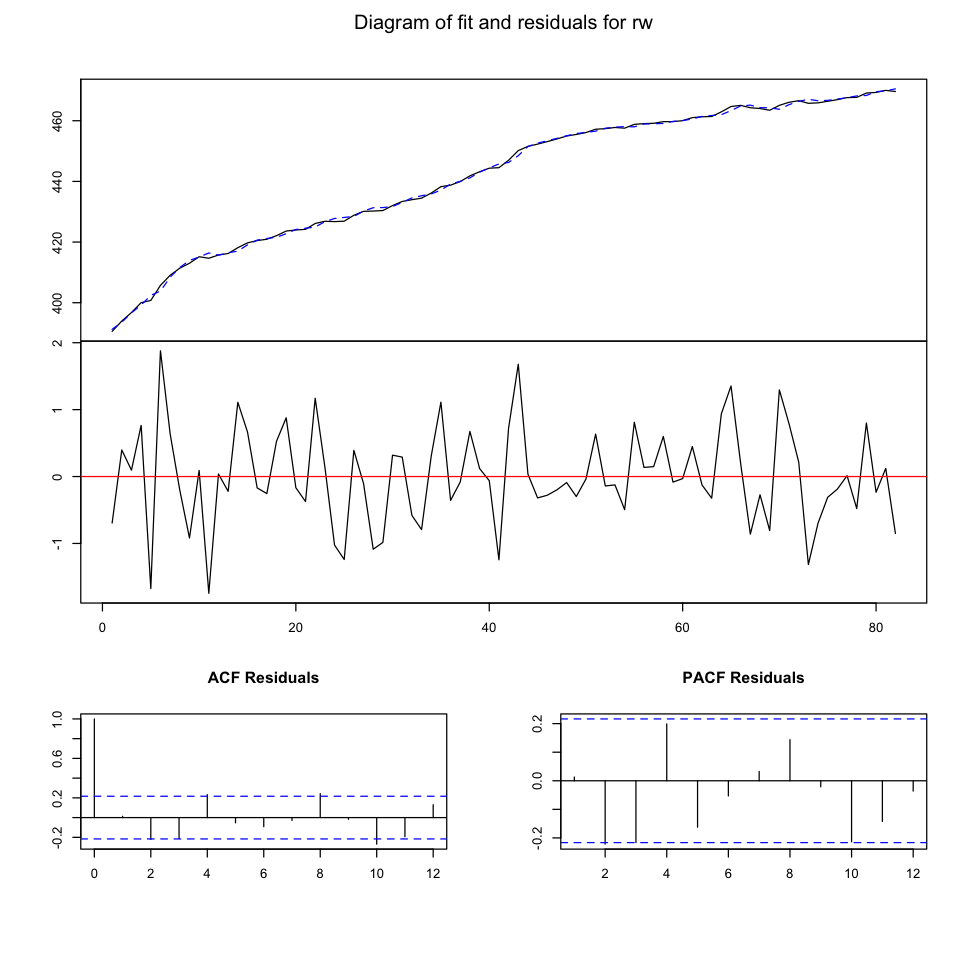


	Portmanteau Test (asymptotic)

data:  Residuals of VAR object es3
Chi-squared = 146.34, df = 160, p-value = 0.773

$serial

	Portmanteau Test (asymptotic)

data:  Residuals of VAR object es3
Chi-squared = 146.34, df = 160, p-value = 0.773



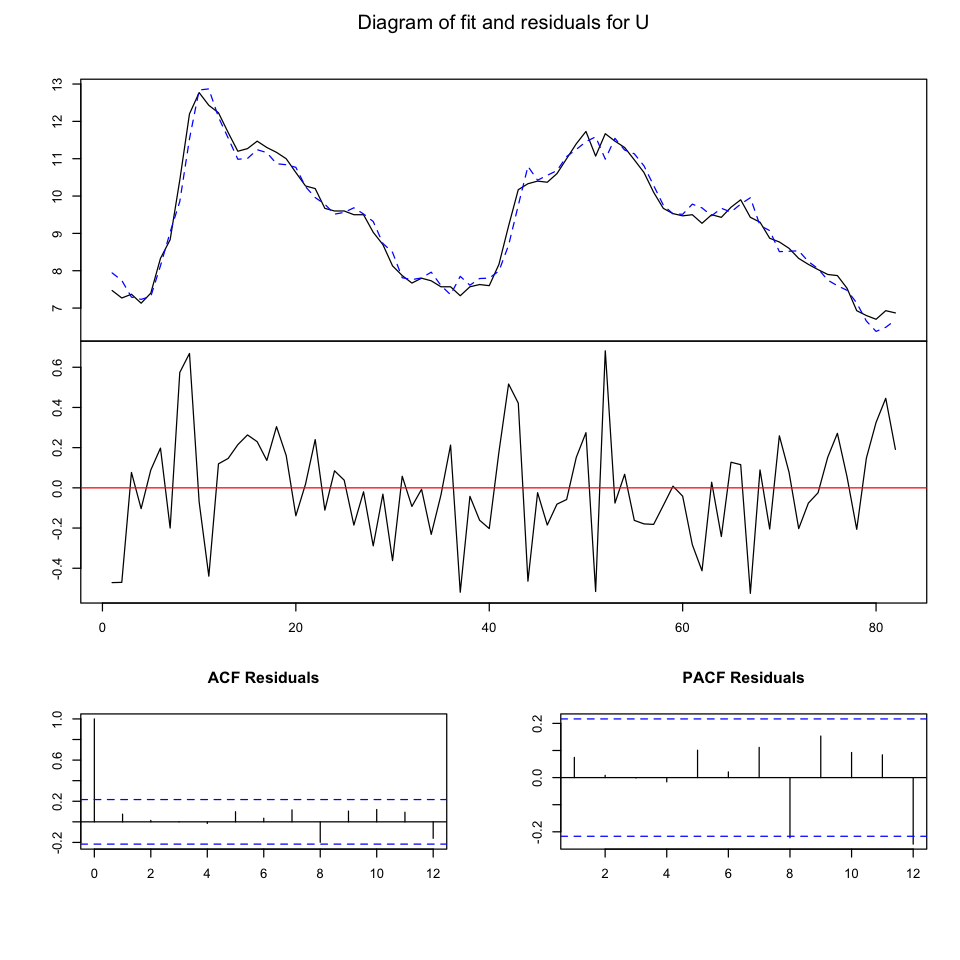


	ARCH (multivariate)

data:  Residuals of VAR object es3
Chi-squared = 700, df = 1200, p-value = 1

$arch.mul

	ARCH (multivariate)

data:  Residuals of VAR object es3
Chi-squared = 700, df = 1200, p-value = 1



$JB

	JB-Test (multivariate)

data:  Residuals of VAR object es3
Chi-squared = 2.465, df = 8, p-value = 0.9633


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object es3
Chi-squared = 1.3722, df = 4, p-value = 0.849


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object es3
Chi-squared = 1.0928, df = 4, p-value = 0.8954


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object es3
Chi-squared = 2.465, df = 8, p-value = 0.9633


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object es3
Chi-squared = 1.3722, df = 4, p-value = 0.849


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object es3
Chi-squared = 1.0928, df = 4, p-value = 0.8954




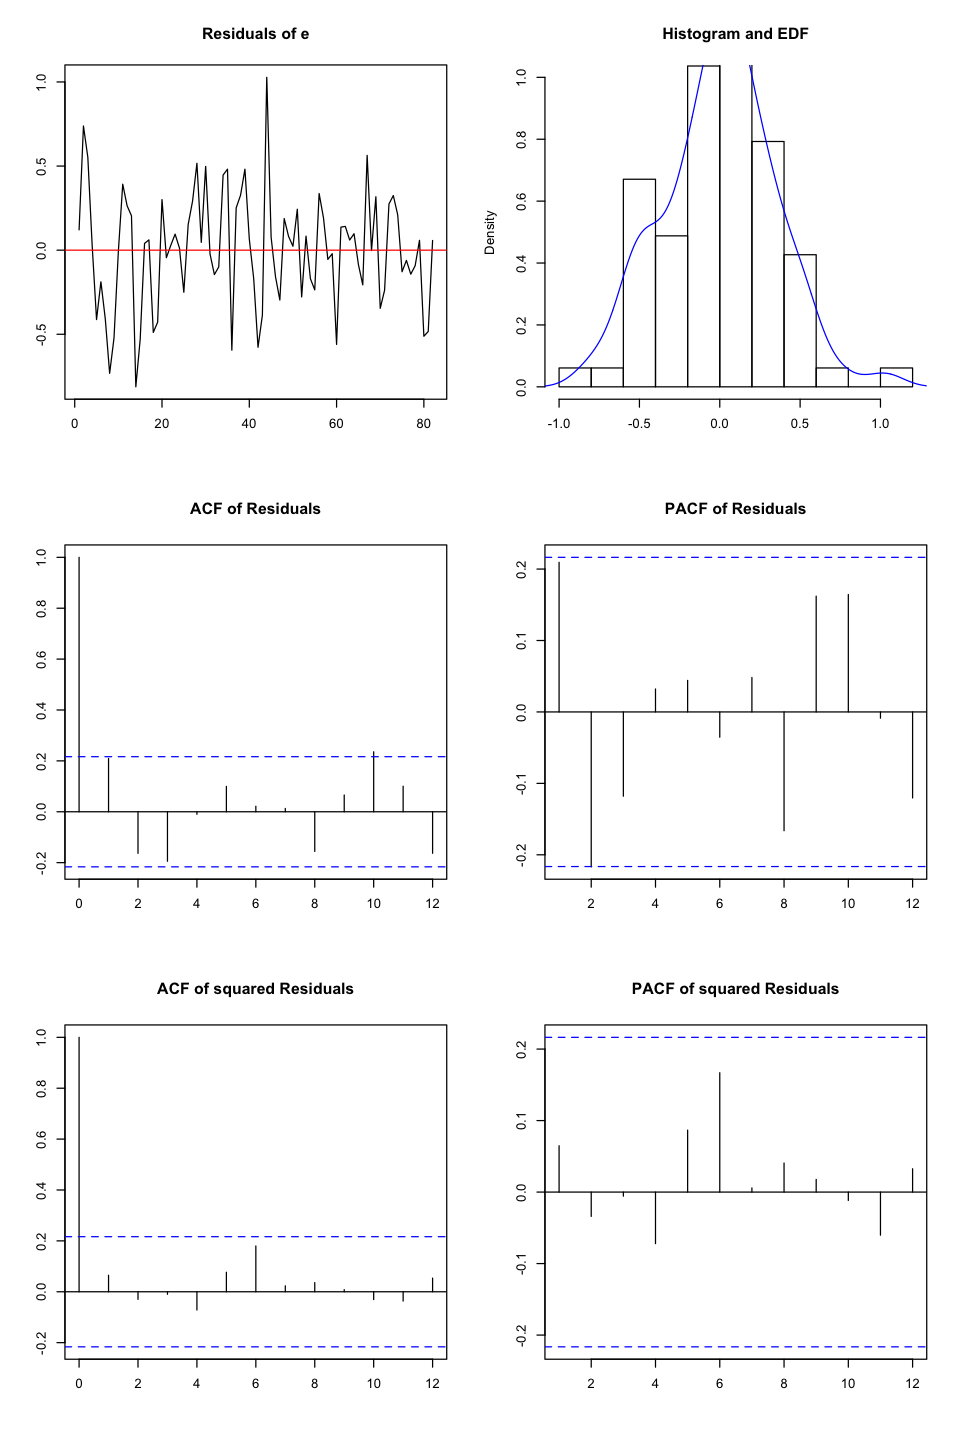

In [29]:
plot(es3)
options(repr.plot.width=8, repr.plot.height=12)
es3.serial <- serial.test(es3, lags.pt = 12, type = "PT.asymptotic")
es3.serial
plot(es3.serial, names = "e")
es3.arch <- arch.test(es3, lags.multi = 12, multivariate.only = TRUE)
es3.arch
es3.norm <- normality.test(es3, multivariate.only = TRUE)
es3.norm

## Results interpretation
Lots of coefficients... but not that interesting

We look at 

* Granger Causality
* Impulse responses (IRF)
* Variance Decompositions (FEVD)

### Granger Causality
Are variables causal, and useful for forecasting?

In [30]:
causality(es3, cause = "e")
causality(es3, cause = "prod")
causality(es3, cause = "rw")
causality(es3, cause = "U")

$Granger

	Granger causality H0: e do not Granger-cause prod rw U

data:  VAR object es3
F-Test = 5.7683, df1 = 6, df2 = 288, p-value = 1.092e-05


$Instant

	H0: No instantaneous causality between: e and prod rw U

data:  VAR object es3
Chi-squared = 26.113, df = 3, p-value = 9.033e-06



$Granger

	Granger causality H0: prod do not Granger-cause e rw U

data:  VAR object es3
F-Test = 2.6488, df1 = 6, df2 = 288, p-value = 0.01622


$Instant

	H0: No instantaneous causality between: prod and e rw U

data:  VAR object es3
Chi-squared = 0.55599, df = 3, p-value = 0.9064



$Granger

	Granger causality H0: rw do not Granger-cause e prod U

data:  VAR object es3
F-Test = 2.5448, df1 = 6, df2 = 288, p-value = 0.02041


$Instant

	H0: No instantaneous causality between: rw and e prod U

data:  VAR object es3
Chi-squared = 2.189, df = 3, p-value = 0.5341



$Granger

	Granger causality H0: U do not Granger-cause e prod rw

data:  VAR object es3
F-Test = 2.3429, df1 = 6, df2 = 288, p-value = 0.03172


$Instant

	H0: No instantaneous causality between: U and e prod rw

data:  VAR object es3
Chi-squared = 26.088, df = 3, p-value = 9.139e-06



### IRFs
How shocks propagate...

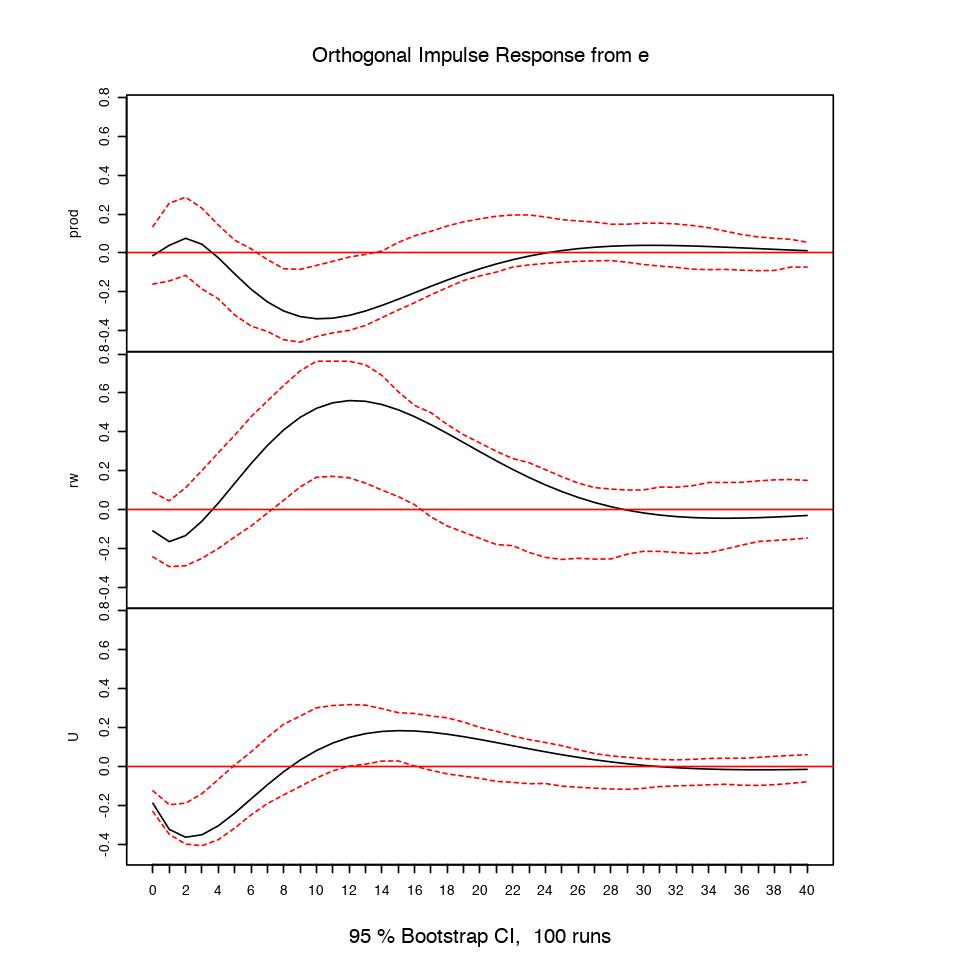

In [39]:
irf1 <- irf(es3, impulse = "e",  n.ahead = 40,response = c("prod", "rw", "U"), boot =TRUE)
plot(irf1)

Positive shock to employment has negavive impact on productivity, increases real wages in horizon of 12 quarters, and decreases unemployment in short run.

### FEVDs
How much of future variability of data is explained by shocks to other variables?

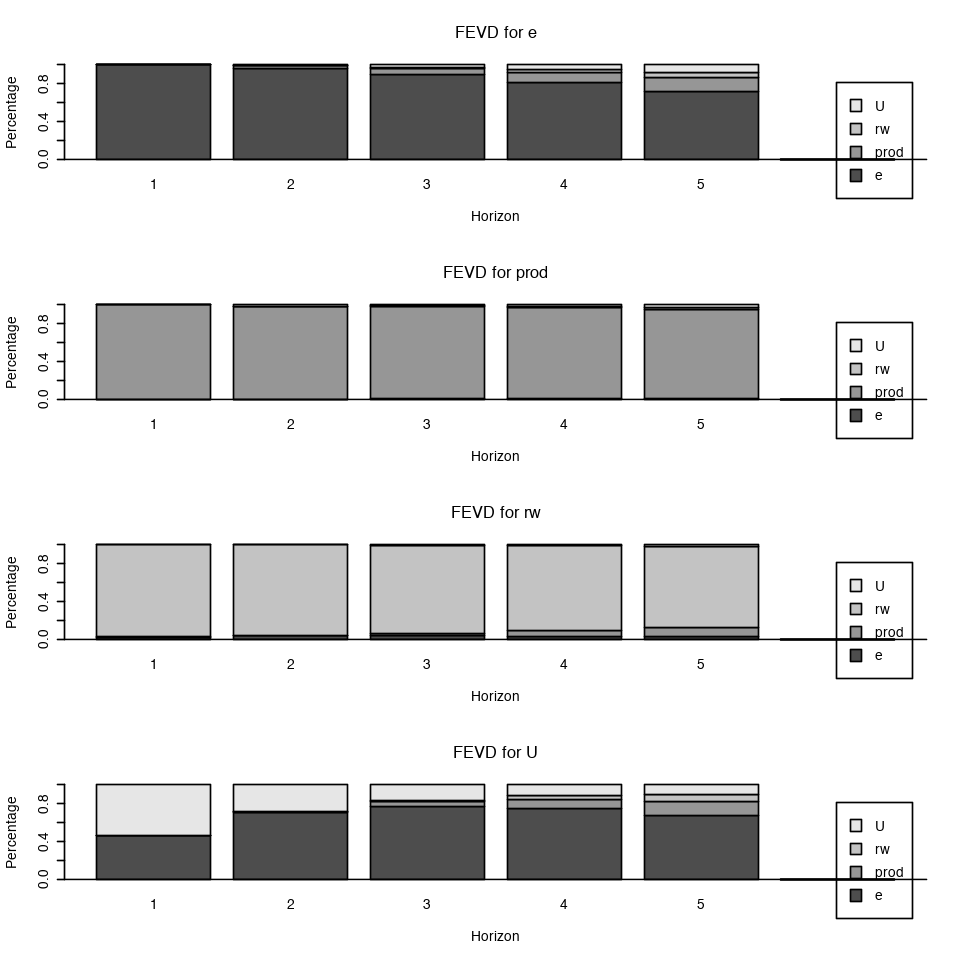

In [40]:
plot(fevd(es3, n.ahead = 5))

## Forecasting

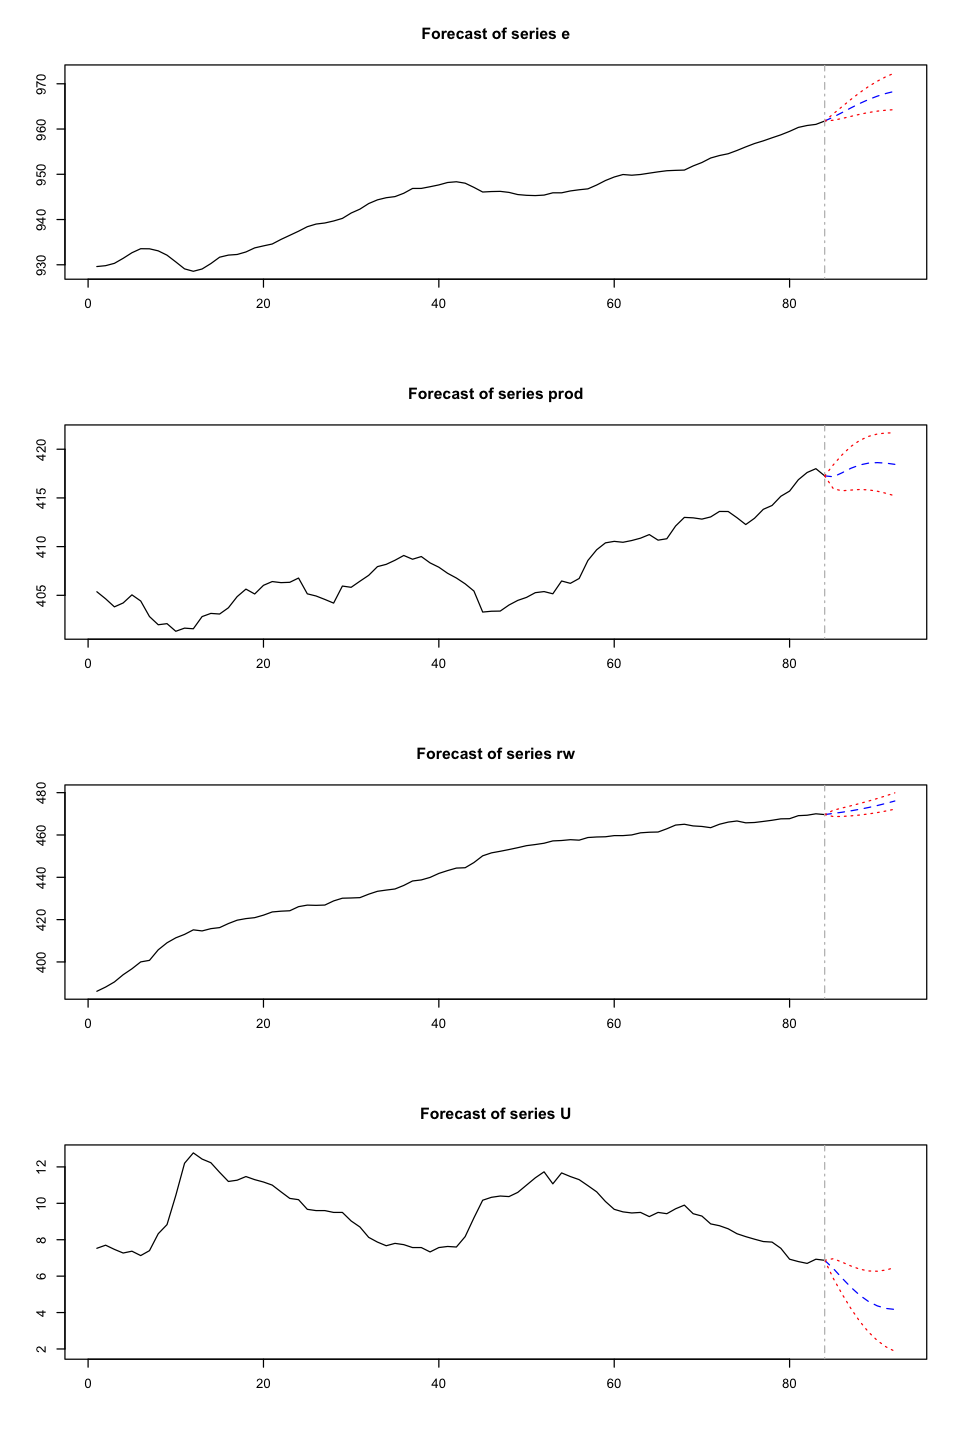

In [35]:
options(repr.plot.width=8, repr.plot.height=12)

predictions <- predict(es3, n.ahead = 8, ci = 0.95)
plot(predictions)

We can produce nice fancharts too

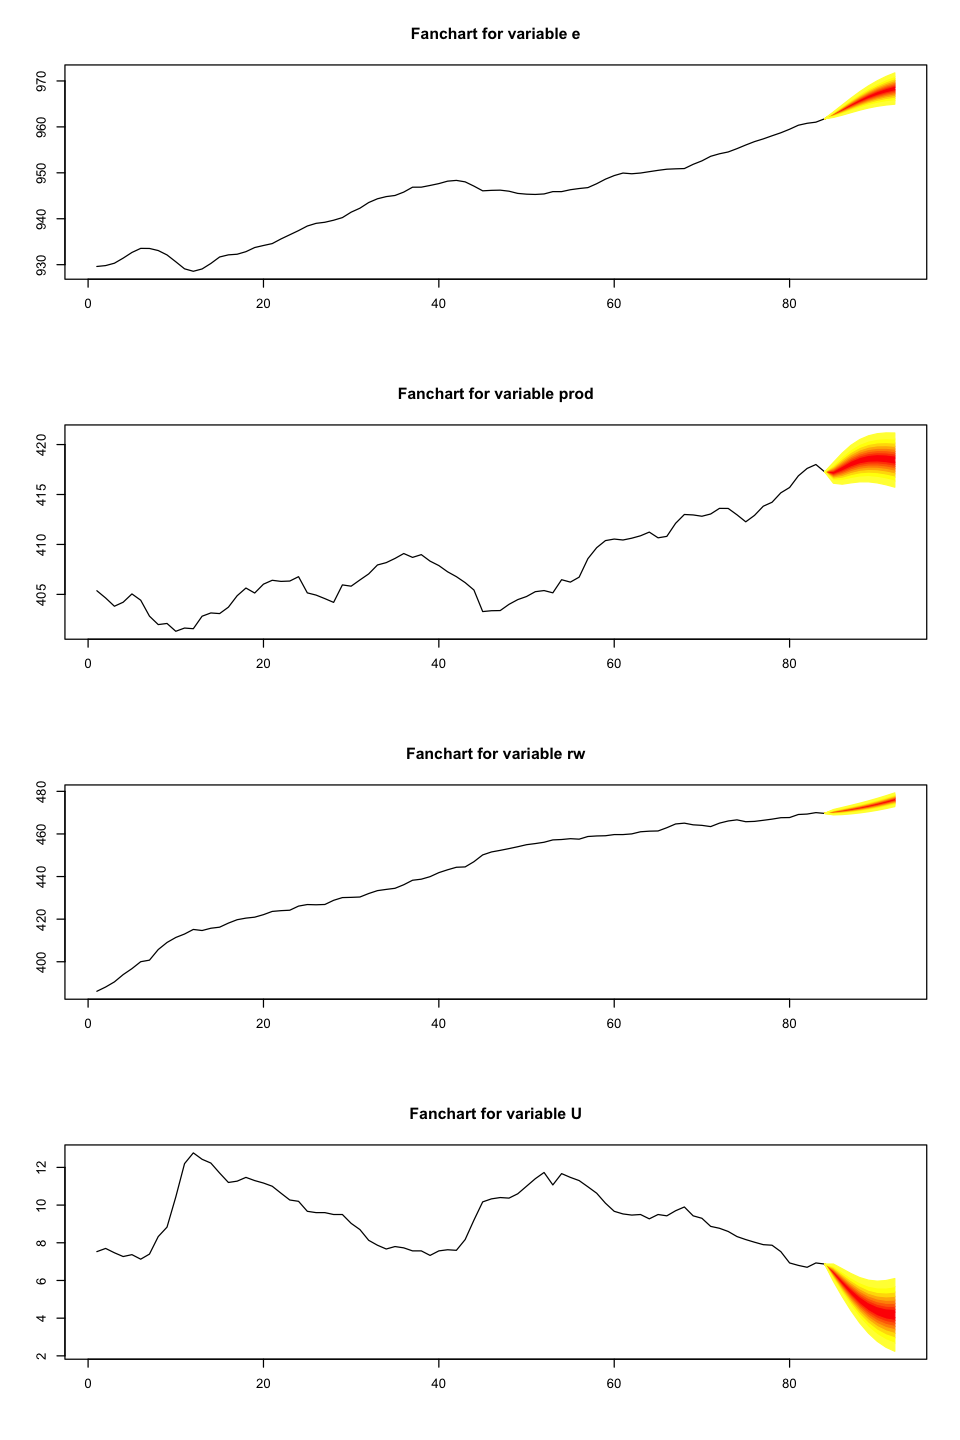

In [36]:
fanchart(predictions,colors=heat.colors(10, alpha = 1))

## A route toward machine learning

These systems are problematic with large variables: lots of parameters to be estimated.

We can use lasso/shrinkage/penalization to "let the machine choose" important parameters.

While this works, we loose some interpretation.

What it allows is large dimension (think: how many parameters we need to estimate on VAR(2) on 30 variable system?)


### Classical versus Lasso estimates
* VAR(2) versus lasso VAR forecast

In [32]:
library(fastVAR)

,e,prod,rw,U
intercept,-7.40283271,-12.10691705,-1.046262e+02,143.301358984
e.l1,0.94008378,0.01318042,0.000000e+00,-0.354433816
prod.l1,0.15591400,0.99600262,-8.926584e-02,-0.074959299
rw.l1,0.00000000,0.00000000,5.868686e-01,0.020018504
U.l1,0.00000000,0.00000000,0.000000e+00,0.809685896
e.l2,0.00000000,0.00000000,0.000000e+00,0.135881529
prod.l2,0.00000000,0.00000000,-6.873752e-04,0.035551614
rw.l2,0.00000000,0.00000000,1.603942e-01,0.037373428
U.l2,0.00000000,0.02169673,0.000000e+00,-0.252820082
e.l3,0.00000000,0.00000000,1.986367e-01,0.058637422


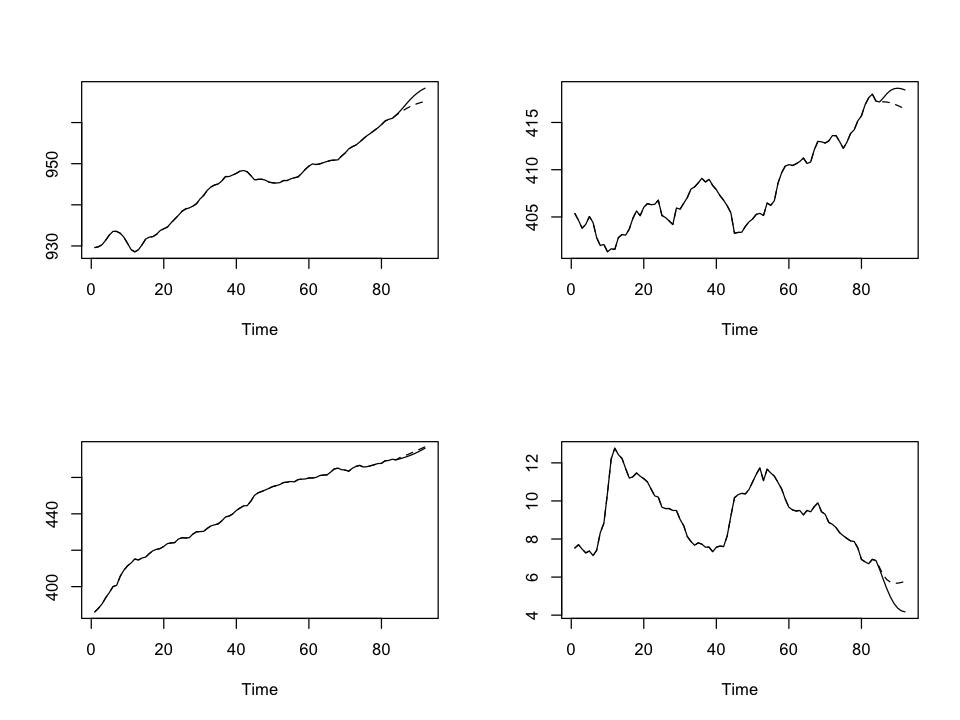

In [37]:
options(repr.plot.width=8, repr.plot.height=6)

e1<-SparseVAR(Canada, p = 3)

coef(e1)
b<- predict(e1,8)

par(mfrow=c(2,2))
plot.ts(c(Canada[,1],predictions$fcst$e[,1]),ylab="")
lines(c(Canada[,1],b[,1]),lty=2)

plot.ts(c(Canada[,2],predictions$fcst$prod[,1]),ylab="")
lines(c(Canada[,2],b[,2]),lty=2)

plot.ts(c(Canada[,3],predictions$fcst$rw[,1]),ylab="")
lines(c(Canada[,3],b[,3]),lty=2)

plot.ts(c(Canada[,4],predictions$fcst$U[,1]),ylab="")
lines(c(Canada[,4],b[,4]),lty=2)